In [1]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score 
from xgboost import XGBClassifier, plot_importance


In [2]:
# 데이터 로드
df = pd.read_csv('05_merged_dataset.csv')

# 결측치 제거 및 클러스터링 대상 피처(premium_ratio) 추출
df_clean = df.dropna(subset=['premium_ratio']).copy()
X_cluster = df_clean[['premium_ratio']]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"분석 대상 데이터 수: {len(X_scaled)}개\n")

분석 대상 데이터 수: 165139개



## step1. 최적의 K 찾기

In [3]:
# 평가할 K의 범위 : k의 범위를 2에서 6까지 한정
k_range = range(2, 7)
inertias = []
silhouette_scores = []

for k in k_range:
    # K-Means 모델 학습
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # 관성 계산: Elbow Method용
    inertias.append(kmeans.inertia_)
    
    # 실루엣 점수 계산
    score = silhouette_score(X_scaled, labels, sample_size=5000, random_state=42)
    silhouette_scores.append(score)
    
    print(f"   ▶ [K={k}] 일때 실루엣 점수: {score:.4f}")

   ▶ [K=2] 일때 실루엣 점수: 0.9034
   ▶ [K=3] 일때 실루엣 점수: 0.7129
   ▶ [K=4] 일때 실루엣 점수: 0.6176
   ▶ [K=5] 일때 실루엣 점수: 0.5947
   ▶ [K=6] 일때 실루엣 점수: 0.5788


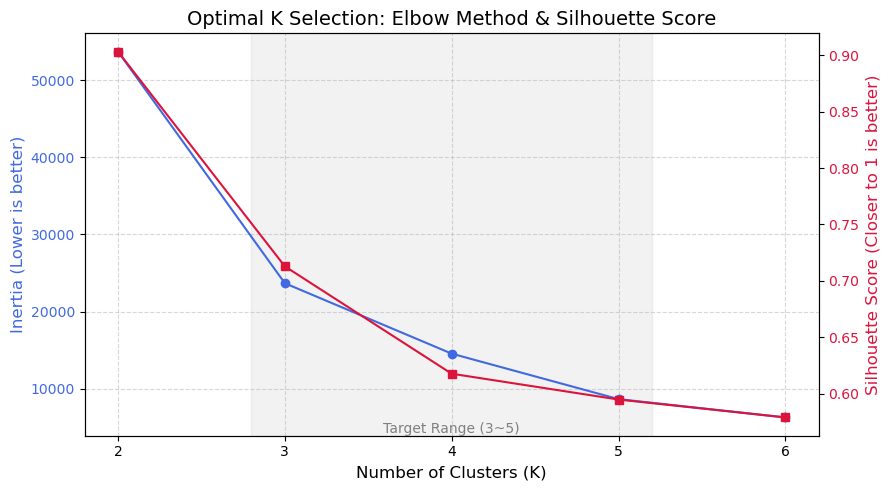

In [4]:
# 결과 시각화 
fig, ax1 = plt.subplots(figsize=(9, 5))

# 관성(Inertia) 그래프 (파란색)
ax1.plot(k_range, inertias, marker='o', color='royalblue', label='Inertia (Elbow)')
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Inertia (Lower is better)', color='royalblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.set_xticks(k_range)
ax1.grid(True, linestyle='--', alpha=0.5)

# 실루엣 점수 그래프 (빨간색)
ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, marker='s', color='crimson', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score (Closer to 1 is better)', color='crimson', fontsize=12)
ax2.tick_params(axis='y', labelcolor='crimson')

# 목표 범위(3~5) 시각적 강조
ax1.axvspan(2.8, 5.2, color='gray', alpha=0.1)
plt.text(4, ax2.get_ylim()[0], 'Target Range (3~5)', ha='center', va='bottom', color='gray', fontsize=10)

plt.title('Optimal K Selection: Elbow Method & Silhouette Score', fontsize=14)
fig.tight_layout()
plt.show()

# Step2.모델 학습

In [5]:
# 데이터 로드
df = pd.read_csv('05_merged_dataset.csv')
df_clean = df.dropna(subset=['premium_ratio']).copy()
print(f"분석 대상 데이터 수: {len(df_clean)}개")

분석 대상 데이터 수: 165139개


In [6]:
#로그 스케일
df_clean['log_premium_ratio'] = np.log1p(df_clean['premium_ratio'])

scaler = StandardScaler()
premium_scaled = scaler.fit_transform(df_clean[['log_premium_ratio']])
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_clean['premium_lable'] = kmeans.fit_predict(premium_scaled)

# 라벨 정렬 (0: 하락 ~ 4: 폭등)
order = df_clean.groupby('premium_lable')['premium_ratio'].mean().sort_values().index
mapping = {old: new for new, old in enumerate(order)}
df_clean['premium_lable'] = df_clean['premium_lable'].map(mapping)

In [7]:
# (전체 정확도를 높이되, 과적합을 막는 완만한 스케일링 적용)
def calculate_balanced_weight(row):
    base = (row['google_trend_release'] * row['google_trend_n_day']) / \
           (row['google_trend_release'] + row['google_trend_n_day'] + 1)
    
    p_ratio = row['premium_ratio']
    weight = 1 + np.log1p(max(0, p_ratio)) * 3 
    return base * weight

df_clean['adjusted_google_trend'] = df_clean.apply(calculate_balanced_weight, axis=1)
# 프리미엄 비율을 더하되, 제곱근(np.sqrt)으로 극단적인 값을 완화
df_clean['wish_per_day'] = (df_clean['wish_count'] * (1 + np.sqrt(abs(df_clean['premium_ratio'])))) / (df_clean['days_since_first_trade'] + 1)
df_clean['trend_retention'] = df_clean['google_trend_n_day'] / (df_clean['google_trend_release'] + 1)
df_clean['wish_efficiency'] = (df_clean['cum_trade_count_product'] * (1 + np.sqrt(abs(df_clean['premium_ratio'])))) / (df_clean['wish_count'] + 1)
df_clean['log_release_price'] = np.log1p(df_clean['release_price'])
df_clean['adjusted_wish'] = df_clean['wish_per_day']

In [8]:
# train, test set 분리
drop_cols = ['product_id', 'first_trade_date', 'trade_date', 'release_date', 
             'current_price', 'premium_ratio', 'premium_lable', 'log_premium_ratio']
X = df_clean.drop(columns=drop_cols)
y = df_clean['premium_lable']
groups = df_clean['product_id']

# GroupShuffleSplit 분리
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [9]:
# 라벨 2(상승가능성)에 2~2.5배의 가중치, 상대적으로 개수가 적은 3,4 에 1.2배의 가중치를 주어 학습 집중력 향상
class_weights = {0: 1.0, 1: 1.0, 2: 2.5, 3: 1.2, 4: 1.2}
sample_weights = np.array([class_weights[label] for label in y_train])

xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,       
    max_depth=10,             
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    tree_method='hist'
)

xgb_model.fit(X_train, y_train, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [10]:
# 전체 신발 모델(종류) 수 확인
total_products = df_clean['product_id'].nunique()
print(f"분석에 사용된 전체 신발 종류: {total_products}종")

train_products = X_train.index.map(df_clean['product_id']).unique().nunique()
test_products = X_test.index.map(df_clean['product_id']).unique().nunique()

print(f"학습에 사용된 신발: {train_products}종")
print(f"검증(테스트)에 사용된 신발: {test_products}종")

분석에 사용된 전체 신발 종류: 114종
학습에 사용된 신발: 91종
검증(테스트)에 사용된 신발: 23종


In [11]:
# 1. 테스트 세트에 포함된 전체 데이터 추출
test_data = df_clean.iloc[test_idx]

# 2. 테스트 세트에 포함된 고유 상품 번호(product_id) 추출
test_product_ids = test_data['product_id'].unique()

print(f"테스트 세트에 사용된 고유 상품 수: {len(test_product_ids)}개")
print("테스트 상품 번호 리스트 :")
print(test_product_ids[:24])



테스트 세트에 사용된 고유 상품 수: 23개
테스트 상품 번호 리스트 :
[    36 368908 783522 138416 282500 402232 526264 611602 611603  18402
  23879  24137  28029 612674  65219 643434 441846 751978 309629 542407
 547201 555990 748535]


## Step3.모델 테스트

[테스트 세트 평가 결과]
Accuracy: 0.7940

              precision    recall  f1-score   support

           0       0.63      0.33      0.44      8735
           1       0.68      0.89      0.77     15310
           2       0.98      0.96      0.97     10385
           3       1.00      0.96      0.98      4544
           4       0.94      0.99      0.97       958

    accuracy                           0.79     39932
   macro avg       0.85      0.83      0.82     39932
weighted avg       0.79      0.79      0.78     39932



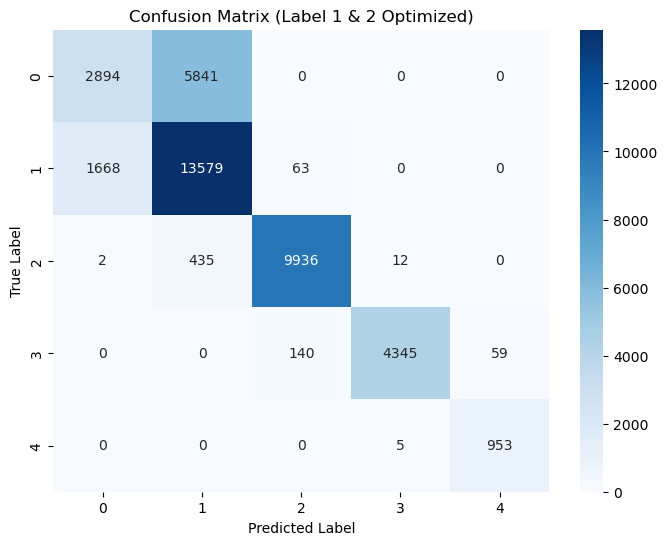

<Figure size 1000x800 with 0 Axes>

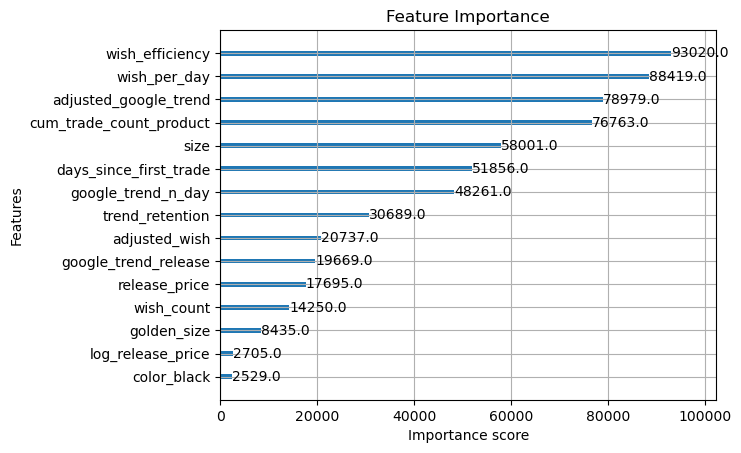

In [12]:
# 모델 테스트
y_pred = xgb_model.predict(X_test)

print("[테스트 세트 평가 결과]")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Label 1 & 2 Optimized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance 시각화
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance')
plt.show()

## Step4.새로운 테스트 세트 적용해보기 
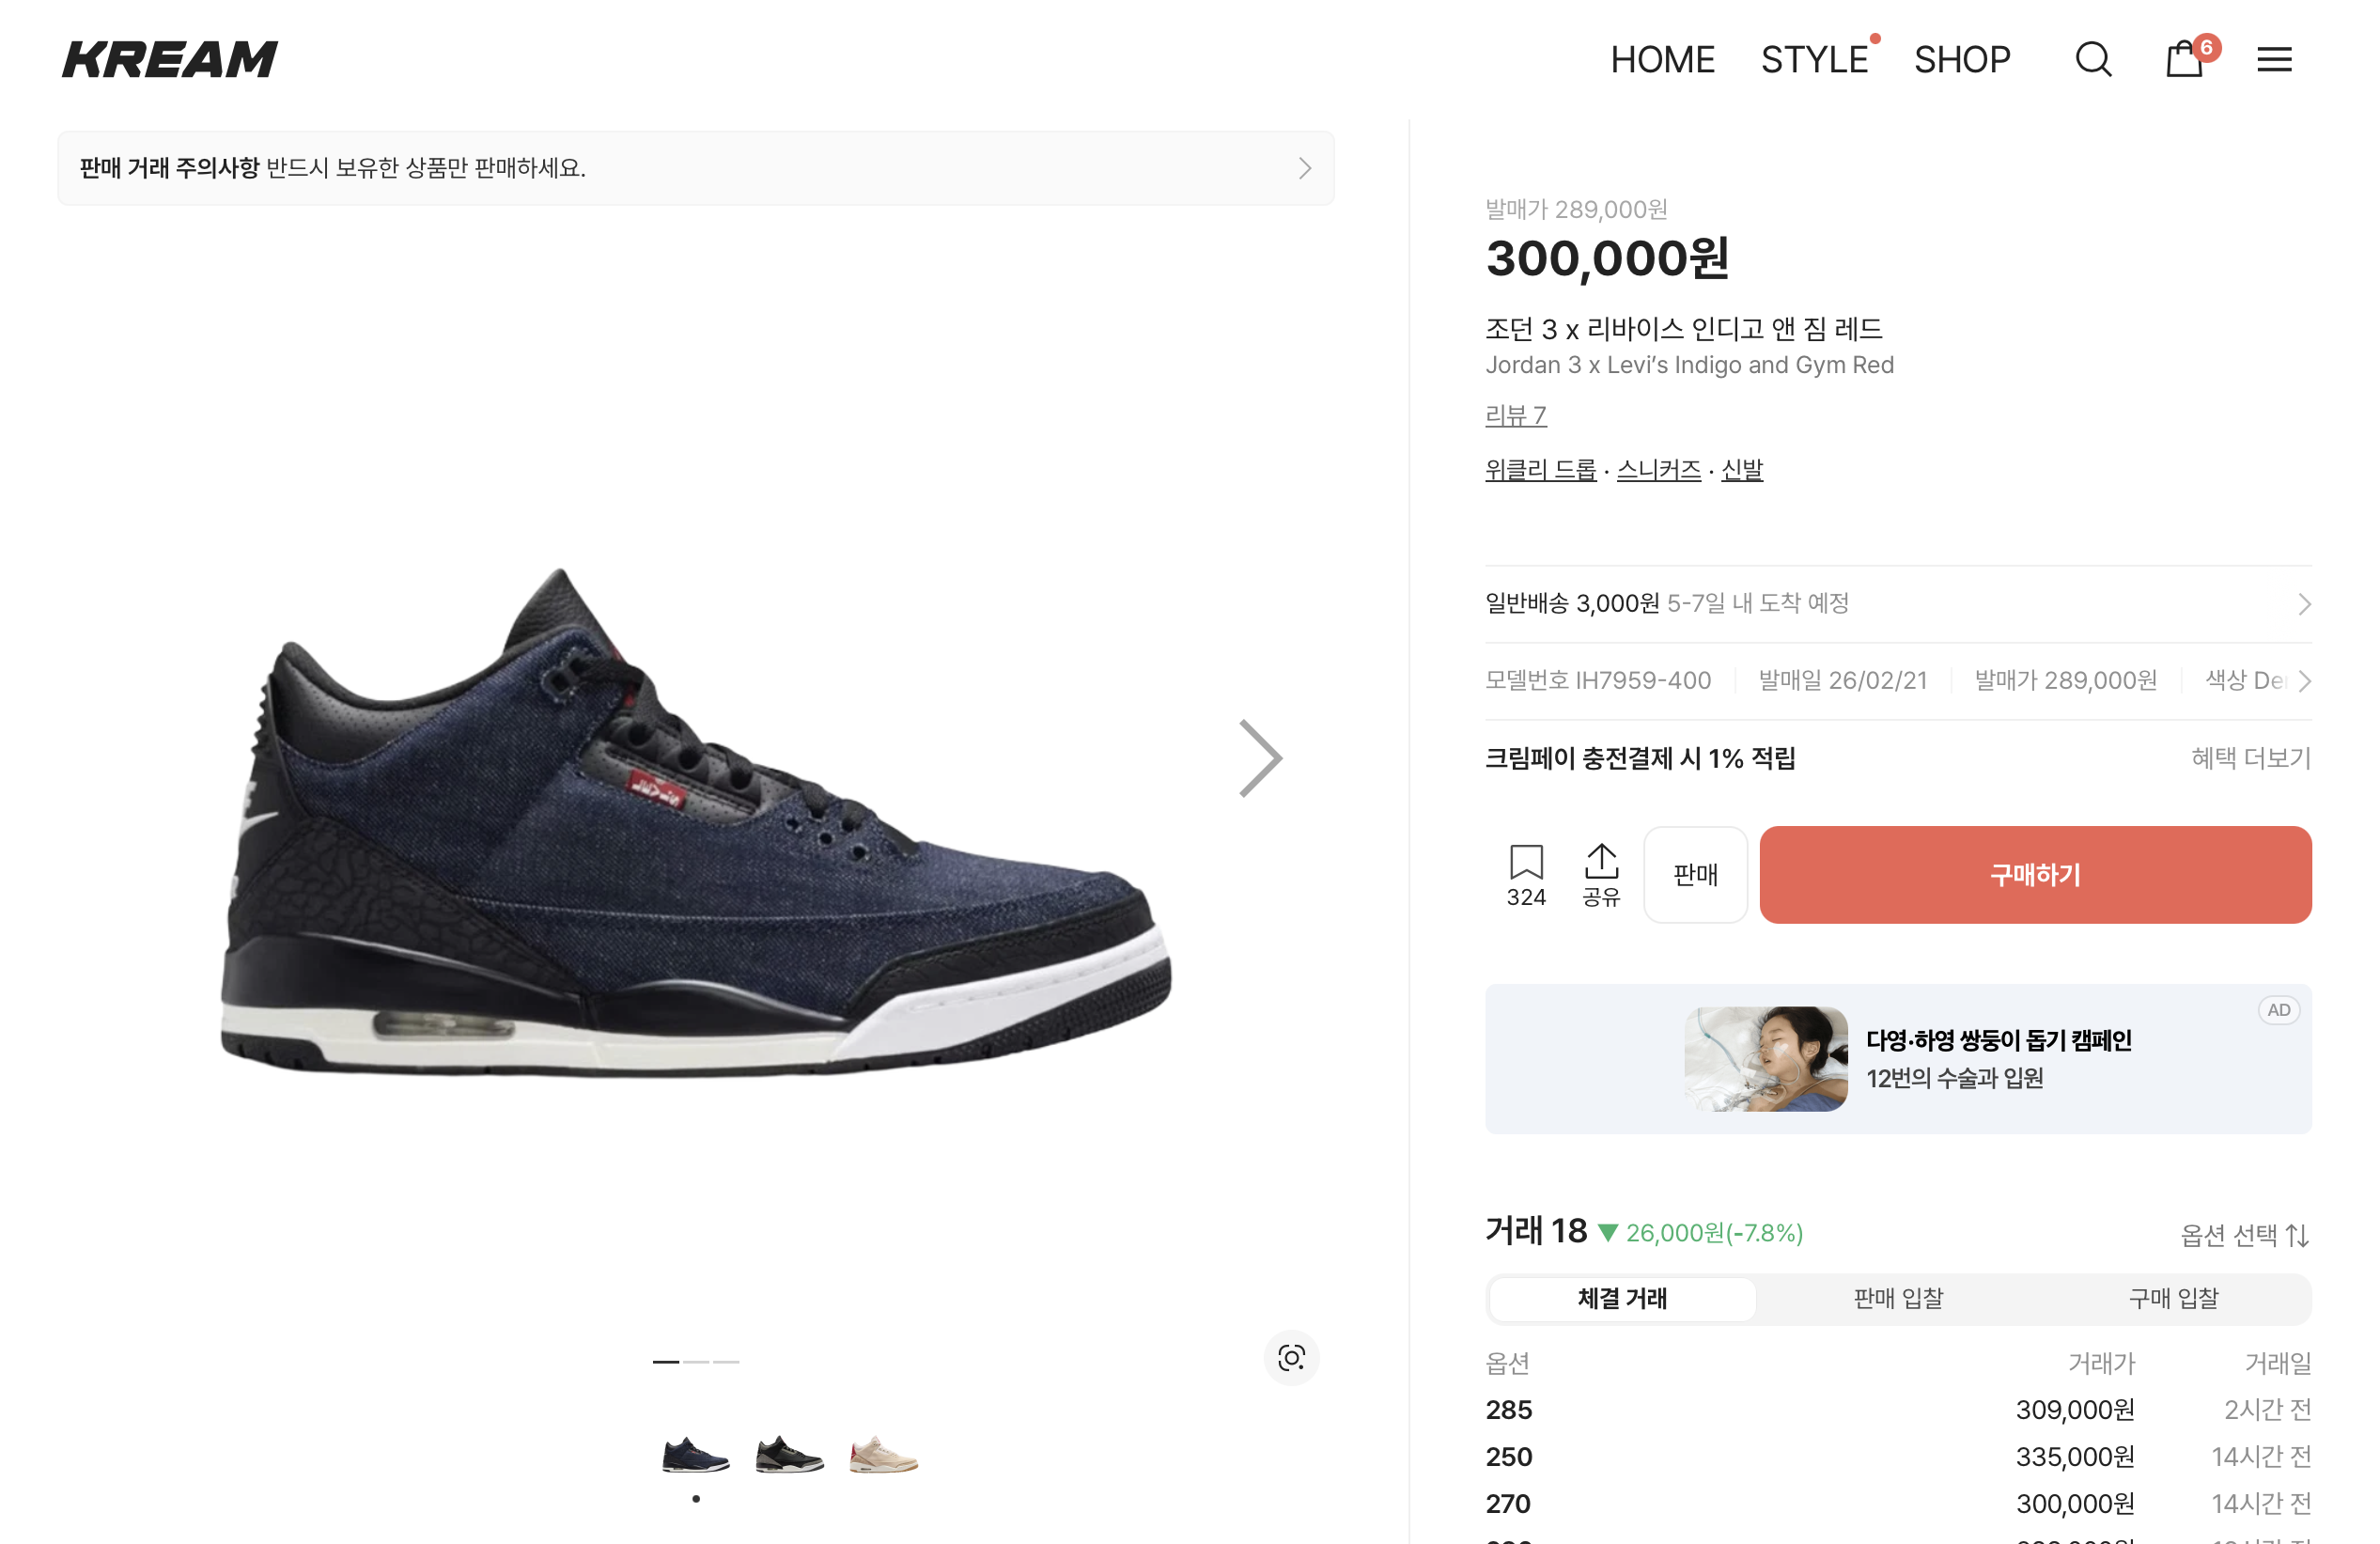

In [13]:
new_shoes_data = {
    'product_id': [791202],
    'release_price': [289000],
    'is_collaboration': [0],
    'color_white': [0], 'color_black': [1], 'color_grey': [0], 
    'color_brown': [0], 'color_pink': [0], 'color_blue': [0], 
    'color_navy': [0], 'color_green': [0], 'color_red': [0], 
    'color_orange': [0], 'color_yellow': [0],
    'size': [275],
    'golden_size': [1],
    'days_since_first_trade': [2],
    'current_price': [300000],
    'cum_trade_count_product': [18],
    'wish_count': [324],
    'google_trend_release': [71],
    'google_trend_n_day': [69]
}
final_df = pd.DataFrame(new_shoes_data)

# 예측 데이터에도 학습과 완벽히 동일한 파생 변수 로직 적용
final_df['premium_ratio'] = (final_df['current_price'] - final_df['release_price']) / final_df['release_price']
final_df['adjusted_google_trend'] = final_df.apply(calculate_balanced_weight, axis=1)
final_df['wish_per_day'] = (final_df['wish_count'] * (1 + np.sqrt(abs(final_df['premium_ratio'])))) / (final_df['days_since_first_trade'] + 1)
final_df['trend_retention'] = final_df['google_trend_n_day'] / (final_df['google_trend_release'] + 1)
final_df['wish_efficiency'] = (final_df['cum_trade_count_product'] * (1 + np.sqrt(abs(final_df['premium_ratio'])))) / (final_df['wish_count'] + 1)
final_df['log_release_price'] = np.log1p(final_df['release_price'])
final_df['adjusted_wish'] = final_df['wish_per_day']


final_input = final_df[X.columns]

# XGBoost 모델로 최종 라벨 예측
predicted_label = xgb_model.predict(final_input)[0]


print(f" 해당 상품의 분석 결과: [라벨 {predicted_label}]")

if predicted_label == 0:
    print("[구매 보류] 가격 하락 가능성이 높습니다.")
elif predicted_label == 1:
    print("[안정] 가격이 안정적입니다. 나중에 구매해도 가격 변동이 크지 않을 가능성이 큽니다.")
elif predicted_label == 2:
    print("[구매 추천] 이후 가격이 상승할 가능성이 큽니다. 지금 구매를 추천합니다.")
elif predicted_label == 3:
    print("[가격 상승 중] 현재 가격이 급등하고 있습니다. 예산을 확인해주세요.")
else:
    print("[폭등] 초한정판 가치를 지니고 있어 폭등 중입니다.")


 해당 상품의 분석 결과: [라벨 1]
[안정] 가격이 안정적입니다. 나중에 구매해도 가격 변동이 크지 않을 가능성이 큽니다.


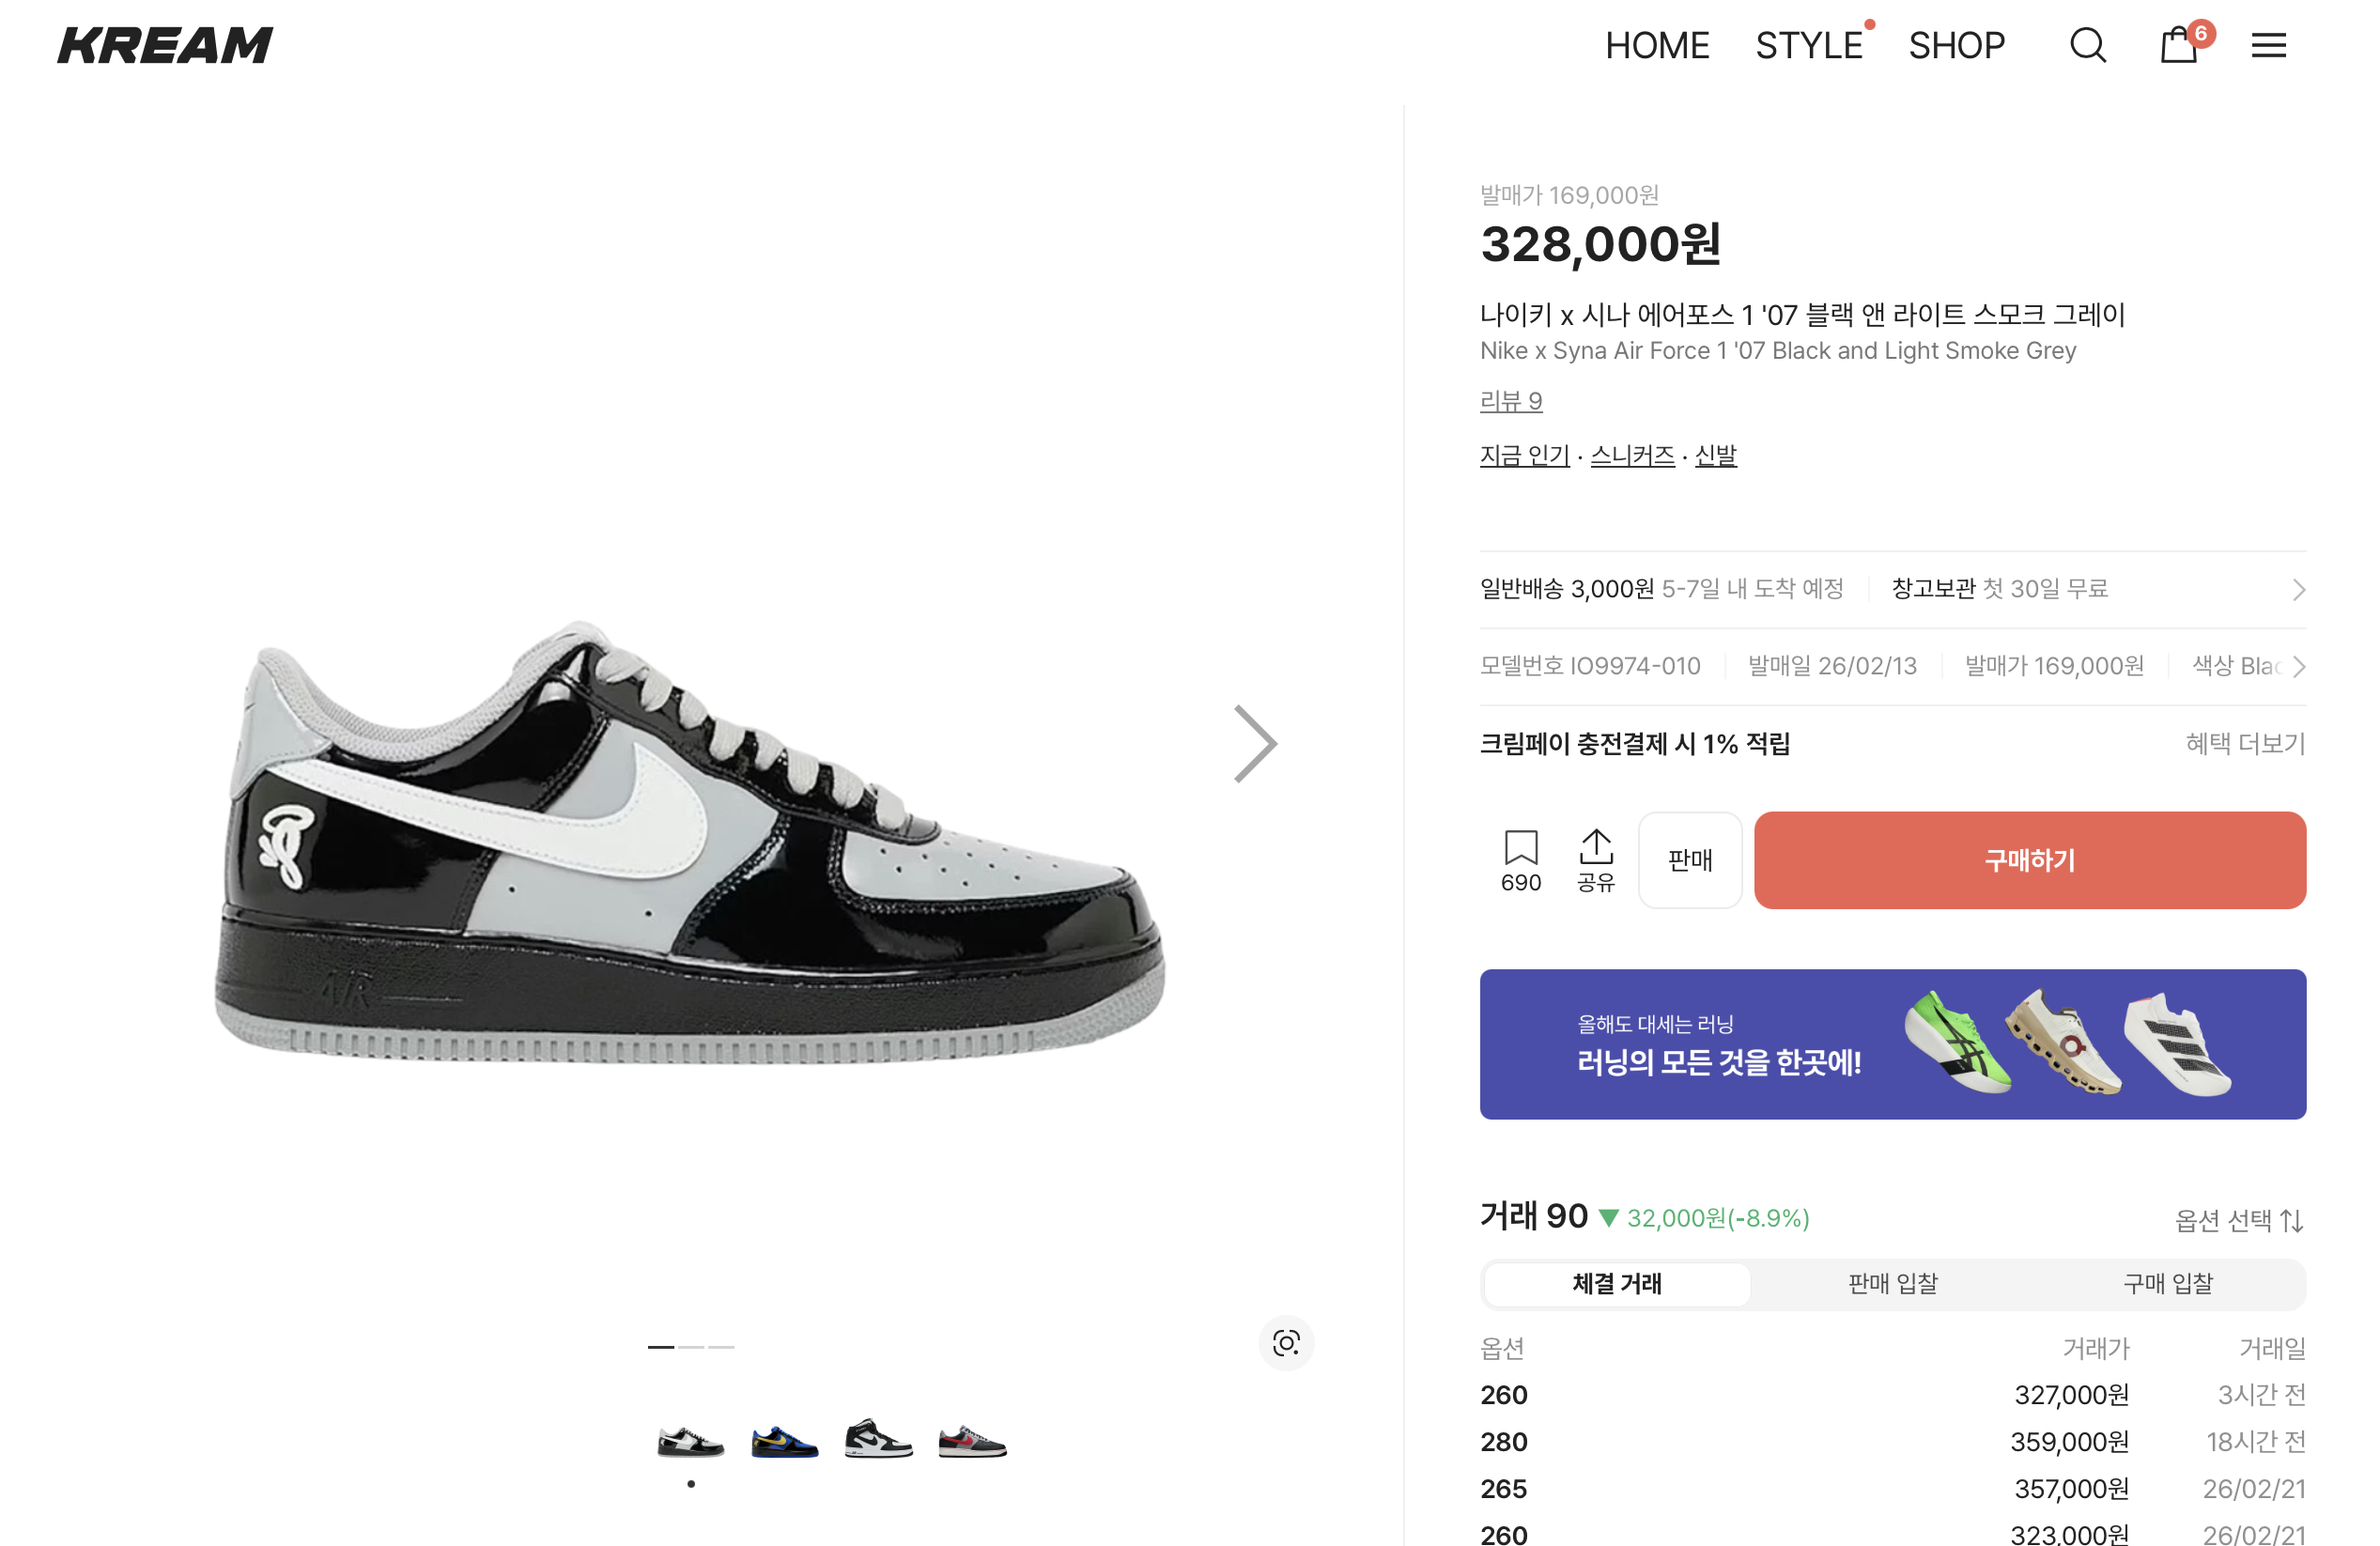

In [14]:
new_shoes_data = {
    'product_id': [783522],
    'release_price': [169000],
    'is_collaboration': [0],
    'color_white': [0], 'color_black': [1], 'color_grey': [0], 
    'color_brown': [0], 'color_pink': [0], 'color_blue': [0], 
    'color_navy': [0], 'color_green': [0], 'color_red': [0], 
    'color_orange': [0], 'color_yellow': [0],
    'size': [270],
    'golden_size': [1],
    'days_since_first_trade': [66],
    'current_price': [384000],
    'cum_trade_count_product': [90],
    'wish_count': [690],
    'google_trend_release': [75],
    'google_trend_n_day': [69]
}
final_df = pd.DataFrame(new_shoes_data)

# 예측 데이터에도 학습과 완벽히 동일한 파생 변수 로직 적용
final_df['premium_ratio'] = (final_df['current_price'] - final_df['release_price']) / final_df['release_price']
final_df['adjusted_google_trend'] = final_df.apply(calculate_balanced_weight, axis=1)
final_df['wish_per_day'] = (final_df['wish_count'] * (1 + np.sqrt(abs(final_df['premium_ratio'])))) / (final_df['days_since_first_trade'] + 1)
final_df['trend_retention'] = final_df['google_trend_n_day'] / (final_df['google_trend_release'] + 1)
final_df['wish_efficiency'] = (final_df['cum_trade_count_product'] * (1 + np.sqrt(abs(final_df['premium_ratio'])))) / (final_df['wish_count'] + 1)
final_df['log_release_price'] = np.log1p(final_df['release_price'])
final_df['adjusted_wish'] = final_df['wish_per_day']

# 학습 시 사용했던 컬럼(X.columns)만 정확히 추출 (product_id 등 불필요한 피처 자동 필터링)
final_input = final_df[X.columns]

# 학습된 XGBoost 모델로 최종 라벨 예측
predicted_label = xgb_model.predict(final_input)[0]

print(f" 해당 상품의 분석 결과: [라벨 {predicted_label}]")

if predicted_label == 0:
    print("[구매 보류] 가격 하락 가능성이 높습니다.")
elif predicted_label == 1:
    print("[안정] 가격이 안정적입니다. 나중에 구매해도 가격 변동이 크지 않을 가능성이 큽니다.")
elif predicted_label == 2:
    print("[구매 추천] 이후 가격이 상승할 가능성이 큽니다. 지금 구매를 추천합니다.")
elif predicted_label == 3:
    print("[가격 상승 중] 현재 가격이 급등하고 있습니다. 예산을 확인해주세요.")
else:
    print("[폭등] 초한정판 가치를 지니고 있어 폭등 중입니다.")

 해당 상품의 분석 결과: [라벨 3]
[가격 상승 중] 현재 가격이 급등하고 있습니다. 예산을 확인해주세요.
